# T4 Lysozyme RBFE with OpenMM and OpenFE tutorial

This example notebook demonstrates how to carry out a relative free energy calculation of the transformation between benzene and phenol in the T4 lysozyme binding site.

## Conventional MD of the benzene system

In the first instance we outline how to run a short conventional MD simulation of one of the ligands using the OpenFF toolkit. This tutorial is inspired by the OpenFF ["using sminorff with AMBER protein forcefield"](https://github.com/openforcefield/openff-toolkit/blob/stable/examples/using_smirnoff_with_amber_protein_forcefield/toluene_in_T4_lysozyme.ipynb).and ["toolkit showcase"](https://github.com/openforcefield/openff-toolkit/blob/stable/examples/toolkit_showcase/toolkit_showcase.ipynb) example notebooks.

In [36]:
# openmm imports
import openmm
from openmm import app, unit
from openmm.app import PME, HBonds, PDBFile, Modeller

# openff imports
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from openmmforcefields.generators import SMIRNOFFTemplateGenerator

# numpy
import numpy as np

# parmed
import parmed

# rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

# viz
import nglview as nv
import mdtraj as mdt
import MDAnalysis as mda

from tqdm import tqdm

In [37]:
# Set force field parameters
omm_forcefield = app.ForceField('amber99sb.xml', 'tip3p.xml')

# Create protein system
prot_pdb = PDBFile('inputs/181L_mod_capped_protonated.pdb')
modeller = Modeller(prot_pdb.topology, prot_pdb.positions)

In [38]:
# Create ligand
ligand = Molecule.from_file('inputs/benzene.sdf')
ligand_positions = ligand.conformers[0]
ligand_topology = ligand.to_topology()

smirnoff = SMIRNOFFTemplateGenerator(forcefield="openff-2.0.0.offxml",
                                     molecules=[ligand])
omm_forcefield.registerTemplateGenerator(smirnoff.generator)

In [ ]:
# Add ligand to the Modeller instance
modeller.add(ligand_topology.to_openmm(), ligand_positions)

# Solvate in 0.15 M NaCl
## Todo - long term switch to saltpy-like approach
modeller.addSolvent(omm_forcefield, model='tip3p', padding=1.2*unit.nanometer, ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions
system = omm_forcefield.createSystem(
    modeller.topology,
    nonbondedMethod=PME,
    nonbondedCutoff=0.9 * unit.nanometer,
    constraints=HBonds,
    rigidWater=True)

topology = modeller.getTopology()
positions = modeller.getPositions()

# The box is about 73 angstroms per side, so add (30, 30, 30) to center the protein
positions = modeller.getPositions() + np.array([30, 30, 30]) * unit.angstrom

In [ ]:
# configure and run a short simulation
integrator = openmm.LangevinIntegrator(298.15 * unit.kelvin, 1 / unit.picosecond, 0.002 * unit.picoseconds)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

nc_reporter = parmed.openmm.NetCDFReporter("short-trajectory.nc", 100)
simulation.reporters.append(nc_reporter)

In [ ]:
# visualise the built system
u = mda.Universe(simulation)
view = nv.show_mdanalysis(u)
view.display(gui=True)
view

In [ ]:
# Do a short energy minimisation followed by a short NVT simulation
simulation.minimizeEnergy()
minimized_state = simulation.context.getState(
    getPositions=True, getEnergy=True, getForces=True
)

# NVT simulations at 298.15 Kelvin
simulation.context.setVelocitiesToTemperature(298.15 * unit.kelvin)
simulation.step(500)

## Exploring the ligands and their atom mappings

Now that we have a base understanding of how to build one of the end states, we next look at the ligand pair for which we wish to capture a relative binding free energy.

In order to morph between the two ligands, we need to create a hybrid system that distinguishes between common (also often known as core) atoms, and those that will be either disappearing or appearing. To achieve this we create an atom mapping which identifies these common atoms.

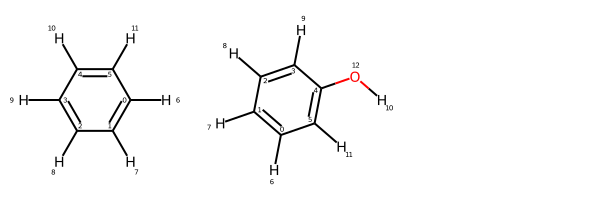

In [39]:
# First let's have a look at our two ligands
benz_mol = Chem.SDMolSupplier('inputs/benzene.sdf', removeHs=False)[0]
phen_mol = Chem.SDMolSupplier('inputs/phenol.sdf', removeHs=False)[0]

# Let's make a copy and look at them in 2D
from copy import deepcopy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True


m1 = deepcopy(benz_mol)
m2 = deepcopy(phen_mol)

AllChem.Compute2DCoords(m1)
AllChem.Compute2DCoords(m2)

Chem.Draw.MolsToGridImage([m1, m2])

mapping:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 12, 11: 11}


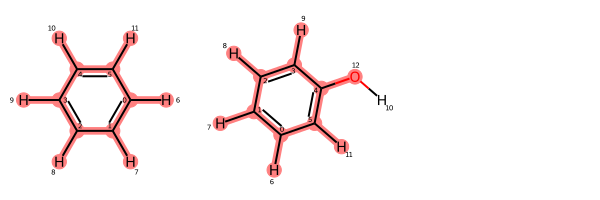

In [40]:
# Next we create an atom mapping between the two molecules using the OpenFE
# toolkit and the Lomap mapper
import openfe
from openfe.setup.lomap_mapper import LomapAtomMapper

mapper = LomapAtomMapper(threed=True)
mapping = next(mapper.suggest_mappings(benz_mol, phen_mol))

# this is a very simple case so all the atoms match each other directly.
print("mapping: ", mapping.mol1_to_mol2)

# Quick temporary hack until Henry's solution gets added
m1_matched_idx = list(mapping.mol1_to_mol2.keys())
m2_matched_idx = list(mapping.mol1_to_mol2.values())

Chem.Draw.MolsToGridImage([m1, m2],
                          highlightAtomLists=[m1_matched_idx, m2_matched_idx])

In [41]:
def disallow_element_changes(mol1, mol2, mapping):
    new_mapping = deepcopy(mapping)
    for key, value in mapping.items():
        at1 = mol1.GetAtoms()[key].GetAtomicNum()
        at2 = mol2.GetAtoms()[value].GetAtomicNum()
        if at1 != at2:
            del new_mapping[key]
    
    return new_mapping

        
new_mol1_to_mol2 = disallow_element_changes(
    benz_mol, phen_mol, mapping.mol1_to_mol2)
print(mapping.mol1_to_mol2)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 12, 11: 11}


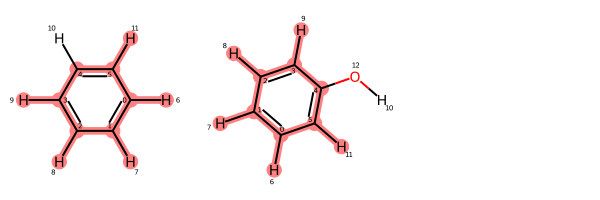

In [42]:
# Quick temporary hack until Henry's solution gets added
m1_matched_idx = list(new_mol1_to_mol2.keys())
m2_matched_idx = list(new_mol1_to_mol2.values())

Chem.Draw.MolsToGridImage(
    [m1, m2], highlightAtomLists=[m1_matched_idx, m2_matched_idx])

In [ ]:
import lomap

MC = lomap.MCS.getMapping(benz_mol, phen_mol, hydrogens=True)


#mapping = [i for i in mcs.MCS.getMapping(benz_mol, phen_mol, hydrogens=True)]
#m1_matched_idx = [i[0] for i in mapping]
#m2_matched_idx = [i[1] for i in mapping]
#Chem.Draw.MolsToGridImage([m1, m2], highlightAtomLists=[m1_matched_idx, m2_matched_idx])

In [ ]:
[i for i in MC]

The above is a rather over simplistic case of atom mapping and doesn't highlight well the power of the Lomap atom mapper toolkit. Here is harder example involving morphine and oxycodone.

In [ ]:
morphine = Chem.MolFromSmiles("CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O")
codeine = Chem.MolFromSmiles("CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C@H]3[C@H](C=C4)O")
oxycodone = Chem.MolFromSmiles("CN1CC[C@]23[C@@H]4C(=O)CC[C@]2([C@H]1CC5=C3C(=C(C=C5)OC)O4)O")

morphine = Chem.AddHs(morphine, explicitOnly=True)
codeine = Chem.AddHs(codeine, explicitOnly=True)
oxycodone = Chem.AddHs(oxycodone, explicitOnly=True)

#for mol in [morphine, codeine, oxycodone]:
#    Chem.rdCoordGen.AddCoords(mol)

# make a copy of the 2D mols
m1 = deepcopy(morphine)
m2 = deepcopy(codeine)
m3 = deepcopy(oxycodone)
    
Chem.Draw.MolsToGridImage([morphine, codeine, oxycodone])

In [ ]:
#AllChem.EmbedMultipleConfs(morphine, numConfs=20, params=AllChem.srETKDGv3())
#AllChem.EmbedMultipleConfs(oxycodone, numConfs=20, params=AllChem.srETKDGv3())

mapper = LomapAtomMapper()
mapping = next(mapper.suggest_mappings(morphine, oxycodone))

In [ ]:
# this is a very simple case so all the atoms match each other directly.
print("mapping: ", mapping.mol1_to_mol2)

# Quick temporary hack until Henry's solution gets added
m1_matched_idx = list(mapping.mol1_to_mol2.keys())
m2_matched_idx = list(mapping.mol1_to_mol2.values())

Chem.Draw.MolsToGridImage([m1, m3], highlightAtomLists=[m1_matched_idx, m2_matched_idx])

In [ ]:
from lomap import mcs

In [ ]:
mapping = [i for i in mapper.getMapping(morphine, codeine, hydrogens=True)]

In [ ]:
m1_matched_idx = [i[0] for i in mapping]
m2_matched_idx = [i[1] for i in mapping]

Chem.Draw.MolsToGridImage([m1, m2], highlightAtomLists=[m1_matched_idx, m2_matched_idx])

In [ ]:
atoms = [at for at in morphine.GetAtoms()]

In [ ]:
for atom in atoms:
    print(atom.GetSymbol())

## Creating a Hybrid Topology for alchemical simulations

Now that we have an atom mapping, we can use it to create a hydrid topology that contains the force field information for both our ligands at the same time.

Note - the HybridTopologyFactory used here is an adapted version of perses' with reduced functionality. The long term aim is to rework this class and push it towards openmmtools.

In [43]:
# First let's create our OFF Molecules for both rdkit molecules
benzene_off = Molecule.from_rdkit(benz_mol)
benzene_top = benzene_off.to_topology()
# switch to using benzene_off.conformers[0] in the future
benzene_pos = unit.Quantity(
    np.zeros([benz_mol.GetNumAtoms(), 3], np.float32), unit.nanometer)
for i, entry in enumerate(benz_mol.GetConformers()[0].GetPositions()):
    benzene_pos[i,:] = unit.Quantity(entry, unit.angstrom)

phenol_off = Molecule.from_rdkit(phen_mol)
phenol_top = phenol_off.to_topology()

phenol_pos = unit.Quantity(
    np.zeros([phen_mol.GetNumAtoms(), 3], np.float32), unit.nanometer)
for i, entry in enumerate(phen_mol.GetConformers()[0].GetPositions()):
    phenol_pos[i,:] = unit.Quantity(entry, unit.angstrom)

In [44]:
smirnoff1 = SMIRNOFFTemplateGenerator(
    forcefield="openff-2.0.0.offxml", molecules=[benzene_off])
omm_forcefield1 = app.ForceField('amber99sb.xml', 'tip3p.xml')
omm_forcefield1.registerTemplateGenerator(smirnoff1.generator)

smirnoff2 = SMIRNOFFTemplateGenerator(
    forcefield="openff-2.0.0.offxml", molecules=[phenol_off])
omm_forcefield2 = app.ForceField('amber99sb.xml', 'tip3p.xml')
omm_forcefield2.registerTemplateGenerator(smirnoff2.generator)


In [45]:
# Let's try to replicate perses a bit
# _setup_complex_phase:
## 1) First they create an mdtraj topology of the protein
## 2) Then they add the old ligand to the mdtraj topology
## 3) Then you check for spectator molecules (skip for us)
## 4) Convert the mdtraj topology to an OpenMM one
## 5) get total, protein, and ligand number of atoms
## 6) get positions for the complex
# _solvate_system (old topology, old positions, box dims, ionic strght)
## Does pretty much what it says on the box
# Create an mdtraj topology from the old_solvated system
# Create a new TopologyProposal
## 1) remove small molecule from old Topology object
## 2) find starting index of small molecule in old Topology object
## 3) get atom indices of molecule in old Topology
## 4) build new topology object with the proposed molecule
#### 
# ?Get a new offset for the atom map?
# _make_new_deterministic_positions
## get old topology and positions, and the atom map between the new and old atoms
## set new positions to be

In [46]:
# create old system
old_modeller = Modeller(prot_pdb.topology, prot_pdb.positions)
old_modeller.add(benzene_top.to_openmm(), benzene_pos)
old_modeller.addSolvent(
    omm_forcefield1, model='tip3p', padding=1.2*unit.nanometer,
    ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions
old_system = omm_forcefield1.createSystem(
                old_modeller.topology,
                nonbondedMethod=PME,
                nonbondedCutoff=0.9 * unit.nanometer,
                constraints=HBonds,
                rigidWater=True)

old_topology = old_modeller.getTopology()
old_positions = old_modeller.getPositions()

# The box is about 73 angstroms per side, so add (30, 30, 30) to center the protein
old_positions = old_modeller.getPositions() + np.array([30, 30, 30]) * unit.angstrom

INFO:	Requested to generate parameters for residue <Residue 164 (benzene) of chain 1>
INFO:	Generating a residue template for [H]c1c(c(c(c(c1[H])[H])[H])[H])[H] using openff-2.0.0.offxml
INFO:	24 torsions added
INFO:	6 impropers added, each applied in a six-fold trefoil
INFO:	12 bonds added (0 skipped due to constraints)
INFO:	18 angles added (0 skipped due to constraints)


In [ ]:
integrator = openmm.LangevinIntegrator(
    298.15 * unit.kelvin, 1 / unit.picosecond, 0.002 * unit.picoseconds)
simulation = app.Simulation(old_topology, old_system, integrator)
simulation.context.setPositions(old_positions)

u = mda.Universe(simulation)
view = nv.show_mdanalysis(u)
view.display(gui=True)
view

In [47]:
## Next we need to be crafty and extract the water + solvent
## this way we can graft in the new ligand]
### deepcopy to not mess with the old modeller
#new_modeller = deepcopy(old_modeller)
### check how many ligands we are starting with
#print("start atoms: ", solv_prot_modeller.topology.getNumAtoms())
### remove the residue we want to delete
#todelete = [r for r in solv_prot_modeller.topology.residues() if r.name == "benzene"]
#new_modeller.delete(todelete)
### there are 12 atoms in a benzene
#print("end atoms: ", solv_prot_modeller.topology.getNumAtoms())

# Using the above isn't working for some reason... need to dig into it
# Let's see if we can do this the same way perses does for now...

# this is a direct copy from perses' topology_proposal.py
def append_topology(destination_topology, source_topology,
                    exclude_residue_name=None):
    """
    Add the source OpenMM Topology to the destination Topology.
    Parameters
    ----------
    destination_topology : simtk.openmm.app.Topology
        The Topology to which the contents of `source_topology` are to be added.
    source_topology : simtk.openmm.app.Topology
        The Topology to be added.
    exclude_residue_name : str, optional, default=None
        If specified, any residues matching this name are excluded.
    """
    destination_topology.setPeriodicBoxVectors(source_topology.getPeriodicBoxVectors())
    if exclude_residue_name is None:
        exclude_residue_name = "   " #something with 3 characters that is never a residue name
    new_atoms = {}
    for chain in source_topology.chains():
        new_chain = destination_topology.addChain(chain.id)
        for residue in chain.residues():
            # TODO: should we use complete residue names?
            if (residue.name[:3] == exclude_residue_name[:3]):
                continue
            new_residue = destination_topology.addResidue(residue.name, new_chain, residue.id)
            for atom in residue.atoms():
                new_atom = destination_topology.addAtom(atom.name, atom.element, new_residue, atom.id)
                new_atoms[atom] = new_atom
    for bond in source_topology.bonds():
        if (bond[0].residue.name[:3] == exclude_residue_name[:3]) or (bond[1].residue.name[:3] == exclude_residue_name[:3]):
            continue
        order = bond.order
        destination_topology.addBond(new_atoms[bond[0]], new_atoms[bond[1]], order=order)
        
receptor_topology = app.Topology()
append_topology(receptor_topology, old_topology, exclude_residue_name="benzene")
receptor_topology._periodicBoxVectors = deepcopy(old_topology._periodicBoxVectors)

# Try to create a "new" topology
new_topology = app.Topology()
append_topology(new_topology, receptor_topology)
append_topology(new_topology, phenol_top.to_openmm())
new_topology._periodicBoxVectors = deepcopy(receptor_topology._periodicBoxVectors)


In [48]:
# Next we create a "new" topology grafting in the phenol
new_system = omm_forcefield2.createSystem(
                 new_topology,
                 nonbondedMethod=PME, nonbondedCutoff=0.9 * unit.nanometer,
                 constraints=HBonds, rigidWater=True)

INFO:	Requested to generate parameters for residue <Residue 11856 (phenol) of chain 4>
INFO:	Generating a residue template for [H]c1c(c(c(c(c1[H])[H])O[H])[H])[H] using openff-2.0.0.offxml
INFO:	26 torsions added
INFO:	6 impropers added, each applied in a six-fold trefoil
INFO:	13 bonds added (0 skipped due to constraints)
INFO:	19 angles added (0 skipped due to constraints)


AttributeError: 'System' object has no attribute 'Topoology'

In [49]:
# Get the indices of the ligand residues in both topologies
## old
_ligres = [res for res in old_topology.residues() if res.name == "benzene"][0]
old_lig_indices = [at.index for at in _ligres.atoms()]

## new
## TODO accidentally named both benzene, change that to ligand or something
_ligres = [res for res in new_topology.residues() if res.name == "phenol"][0]
new_lig_indices = [at.index for at in _ligres.atoms()]

#print(old_lig_indices)
#print(new_lig_indices)

# for now by-hand define atom_mapping
new_to_old_mol_atom_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 11: 11}
new_to_old_adjusted_atom_map = {}
for (key, value) in new_to_old_mol_atom_map.items():
    new_to_old_adjusted_atom_map[key+new_lig_indices[0]] = value + old_lig_indices[0]

#print(new_to_old_adjusted_atom_map)

# reverse the dictionary and get old_to_new_adjusted mapping
old_to_new_adjusted_atom_map = {v: k for k, v in new_to_old_adjusted_atom_map.items()}

# now get lists of unique atoms for old and new
old_unique = [i for i in old_lig_indices if i not in old_to_new_adjusted_atom_map.keys()]
new_unique = [i for i in new_lig_indices if i not in new_to_old_adjusted_atom_map.keys()]

# new_to_old_env (i.e. all env atoms that match exactly)
# assumes that the new system always has the ligand appended to last
new_to_old_env = {}
old_mol_offset = len(old_lig_indices)
old_mol_start_index = old_lig_indices[0]
for i in range(new_lig_indices[0]):
    if i >= old_mol_start_index:
        old_idx = i + old_mol_offset
    else:
        old_idx = i
    new_to_old_env[i] = old_idx

old_to_new_env = {v: k for k, v in new_to_old_env.items()}

#print(new_to_old_env)

In [50]:
old_unique_atoms = [at for at in old_topology.atoms() if at.index in old_unique]
new_unique_atoms = [at for at in new_topology.atoms() if at.index in new_unique]

In [51]:
[at for at in old_topology.atoms() if at.index in old_to_new_adjusted_atom_map.keys()]
[at for at in new_topology.atoms() if at.index in old_to_new_adjusted_atom_map.values()]

[<Atom 37544 (C1x) of chain 4 residue 11856 (phenol)>,
 <Atom 37545 (C2x) of chain 4 residue 11856 (phenol)>,
 <Atom 37546 (C3x) of chain 4 residue 11856 (phenol)>,
 <Atom 37547 (C4x) of chain 4 residue 11856 (phenol)>,
 <Atom 37548 (C5x) of chain 4 residue 11856 (phenol)>,
 <Atom 37549 (C6x) of chain 4 residue 11856 (phenol)>,
 <Atom 37550 (H1x) of chain 4 residue 11856 (phenol)>,
 <Atom 37551 (H2x) of chain 4 residue 11856 (phenol)>,
 <Atom 37552 (H3x) of chain 4 residue 11856 (phenol)>,
 <Atom 37553 (H4x) of chain 4 residue 11856 (phenol)>,
 <Atom 37555 (H6x) of chain 4 residue 11856 (phenol)>]

In [52]:
new_to_old_adjusted_atom_map

{37544: 2612,
 37545: 2613,
 37546: 2614,
 37547: 2615,
 37548: 2616,
 37549: 2617,
 37550: 2618,
 37551: 2619,
 37552: 2620,
 37553: 2621,
 37555: 2623}

In [53]:
# de-map any atoms involved in constrained bonds that undergo length changes
def remove_constraints(atom_map, old_system, new_system, old_topology, new_topology):
    h_elem = app.Element.getByAtomicNumber(1)
    old_hydrogens = [
        at.index for at in old_topology.atoms() if at.element == h_elem]
    new_hydrogens = [
        at.index for at in new_topology.atoms() if at.element == h_elem]
    
    print("before old constraints")
    old_constraints, new_constraints = {}, {}
    for idx in tqdm(range(old_system.getNumConstraints())):
        atom1, atom2, length = old_system.getConstraintParameters(idx)
        if atom1 in old_hydrogens:
            old_constraints[atom1] = length
        if atom2 in old_hydrogens:
            old_constraints[atom2] = length
    
    print("before new constraints")
    for idx in tqdm(range(new_system.getNumConstraints())):
        atom1, atom2, length = new_system.getConstraintParameters(idx)
        if atom1 in new_hydrogens:
            new_constraints[atom1] = length
        if atom2 in new_hydrogens:
            new_constraints[atom2] = length
    
    print("del list creation")
    to_del = []
    for new_index, old_index in atom_map.items():
        if new_index in new_constraints.keys() and old_index in old_constraints.keys():
            if not old_constraints[old_index] == new_constraints[new_index]:
                to_del.append(new_index)
                
    print("deleting")
    for idx in to_del:
        del atom_map[idx]
        
    return atom_map

h_adjusted_atom_map = remove_constraints(
    new_to_old_adjusted_atom_map, old_system,
    new_system, old_topology, new_topology)

before old constraints


100%|██████████| 36184/36184 [00:51<00:00, 698.17it/s] 


before new constraints


100%|██████████| 36184/36184 [01:08<00:00, 527.46it/s] 

del list creation
deleting


In [54]:
h_adjusted_atom_map

{37544: 2612,
 37545: 2613,
 37546: 2614,
 37547: 2615,
 37548: 2616,
 37549: 2617,
 37550: 2618,
 37551: 2619,
 37552: 2620,
 37553: 2621,
 37555: 2623}

In [55]:
# now that we have a new topology and an adjusted atom map
# we need new positions
## based on perses' _make_new_deterministic_positions
new_positions = unit.Quantity(np.zeros((new_topology.getNumAtoms(), 3), np.float32), unit.angstrom)
new_positions[list(new_to_old_env.keys()), :] = old_positions[list(new_to_old_env.values()), :]
new_positions[list(new_lig_indices), :] = phenol_pos[:,:] + np.array([30, 30, 30]) * unit.angstrom

In [19]:
integrator = openmm.LangevinIntegrator(298.15 * unit.kelvin, 1 / unit.picosecond, 0.002 * unit.picoseconds)
simulation = app.Simulation(new_topology, new_system, integrator)
simulation.context.setPositions(new_positions)

In [ ]:
# visualise the built system
u = mda.Universe(simulation)
view = nv.show_mdanalysis(u)
view.display(gui=True)
view

In [21]:
# Do a short energy minimisation followed by a short NVT simulation
simulation.minimizeEnergy()
minimized_state = simulation.context.getState(
    getPositions=True, getEnergy=True, getForces=True
)
# Wohooo it works now!

In [56]:
## work out what the right code is to get newglected_angle_force terms
## for now set both to zero
neglected_new_angle_terms = {}
neglected_old_angle_terms = {}
print(len(neglected_new_angle_terms))

0


In [69]:
## HybridTopologyFactory Breakdown - 1
# Now let's create a hybrid topology factory
## HybridTopologyFactory is essentially a cutdown version of perses'
## that fits around what we need

use_softcore_LJ_v2 = True
softcore_LJ_v2 = True
softcore_electrostatics = True
softcore_LJ_v2_alpha = 0.85
softcore_electrostatics_alpha = 0.3
softcore_sigma_Q = 1.0
dispersion_correction = False
softcore_alpha = 0.5
bond_softening_constant = 1.0
angle_softening_constant = 1.0
soften_only_new = False
interpolate_old_and_new_14s = False
interpolate_14s = interpolate_old_and_new_14s
flatten_torsions = False
soften_bonds = False
soften_angles = False


# first let's define the steps we need for now

# get the forces you need
old_system_forces = {type(force).__name__ : force for force in old_system.getForces()}
new_system_forces = {type(force).__name__ : force for force in new_system.getForces()}

# check for any unknown forces
for forces in [old_system_forces, new_system_forces]:
    force_names = forces.keys()
    known_forces = {'HarmonicBondForce', 'HarmonicAngleForce',
                    'PeriodicTorsionForce', 'NonbondedForce',
                    'MonteCarloBarostat', 'CMMotionRemover'}
    unknown_forces = set(force_names) - set(known_forces)
    ## TODO -- work out why CMMotionRemover is here - remove it?
    if len(unknown_forces) > 0:
        raise ValueError("unknown forces")
    
nonbonded_method = old_system_forces['NonbondedForce'].getNonbondedMethod()

hybrid_system = openmm.System()
hybrid_system_forces = {}
old_to_hybrid_map = {}
new_to_hybrid_map = {}

In [70]:
## HybridTopologyFactory Breakdown - 2
# Add old atoms to system
for particle_idx in range(old_topology.getNumAtoms()):
    mass = old_system.getParticleMass(particle_idx)
    # for now we just assume that we have no changes in masses
    hybrid_idx = hybrid_system.addParticle(mass)
    old_to_hybrid_map[particle_idx] = hybrid_idx
    
    if particle_idx in old_to_new_adjusted_atom_map.keys():
        new_system_index = old_to_new_adjusted_atom_map[particle_idx]
        new_to_hybrid_map[new_system_index] = hybrid_idx
    elif particle_idx in old_to_new_env.keys():
        new_system_index = old_to_new_env[particle_idx]
        new_to_hybrid_map[new_system_index] = hybrid_idx

# Add unique new atoms (old unique atoms have already been added)
for particle_idx in new_unique:
    mass = new_system.getParticleMass(particle_idx)
    hybrid_idx = hybrid_system.addParticle(mass)
    new_to_hybrid_map[particle_idx] = hybrid_idx
    
# copy over the box vectors
box_vectors = old_system.getDefaultPeriodicBoxVectors()
hybrid_system.setDefaultPeriodicBoxVectors(*box_vectors)

# reverse _to_hybrid atom maps
hybrid_to_old_map = {val : key for key, val in old_to_hybrid_map.items()}
hybrid_to_new_map = {val : key for key, val in new_to_hybrid_map.items()}

# next we determine the atom classes (unique old, unique new, core, or env)
atom_classes = {
    'unique_old_atoms': set(),
    'unique_new_atoms': set(),
    'core_atoms': set(),
    'env_atoms': set(),
}

# loop through the old unique atoms
for idx in old_unique:
    hybrid_idx = old_to_hybrid_map[idx]
    atom_classes['unique_old_atoms'].add(hybrid_idx)
    
# then new unique atoms
for idx in new_unique:
    hybrid_idx = new_to_hybrid_map[idx]
    atom_classes['unique_new_atoms'].add(hybrid_idx)
    
# then core atoms - double check this defn what does perses think of core atoms?
core_atoms = []
for new_idx, old_idx in new_to_old_adjusted_atom_map.items():
    new_to_hybrid_idx = new_to_hybrid_map[new_idx]
    old_to_hybrid_idx = old_to_hybrid_map[old_idx]
    if new_to_hybrid_idx != old_to_hybrid_idx:
        raise AssertionError('core atoms do not match!')
    atom_classes['core_atoms'].add(new_to_hybrid_idx)

# new/old to hybrid environment atoms
for new_idx, old_idx in new_to_old_env.items():
    # new_to_hybrid is missing all the env atoms... need to add these to the mapping
    new_to_hybrid_idx = new_to_hybrid_map[new_idx]
    old_to_hybrid_idx = old_to_hybrid_map[old_idx]
    if new_to_hybrid_idx != old_to_hybrid_idx:
        raise AssertionError('env atoms do not match!')
    atom_classes['env_atoms'].add(old_to_hybrid_idx)

In [71]:
## HybridTopologyFactory Breakdown - 3
# construction dictionary of exceptions in old and new systems
# dictionary of exceptions in old and new systems
def generate_dict_from_exceptions(force):
    exceptions_dict = {}
    for exception_idx in range(force.getNumExceptions()):
        idx1, idx2, chargeProd, sigma, epsilon = force.getExceptionParameters(exception_idx)
        exceptions_dict[(idx1, idx2)] = [chargeProd, sigma, epsilon]
    
    return exceptions_dict

old_system_exceptions = generate_dict_from_exceptions(old_system_forces['NonbondedForce'])
new_system_exceptions = generate_dict_from_exceptions(new_system_forces['NonbondedForce'])

# validate disjoint sets
# sanity check to make sure hybrid_maps of the old + new system exception dict keys
# do not contain both env and unique atoms
for old_idx in old_system_exceptions.keys():
    hybrid_idx = (old_to_hybrid_map[old_idx[0]], old_to_hybrid_map[old_idx[1]])
    if set(old_idx).intersection(atom_classes['env_atoms']) != set():
        if set(old_idx).intersection(atom_classes['unique_old_atoms']) != set():
            raise AssertionError('old index exceptions issue')

for new_idx in new_system_exceptions.keys():
    hybrid_idx = (new_to_hybrid_map[new_idx[0]], new_to_hybrid_map[new_idx[1]])
    if set(hybrid_idx).intersection(atom_classes['env_atoms']) != set():
        if set(hybrid_idx).intersection(atom_classes['unique_new_atoms']) != set():
            raise AssertionError('new index exceptions issue')

In [72]:
## HybridTopologyFactory Breakdown - 4
# handle constraints
constraint_lengths = {}
## old system

def add_constraints(constraint_lengths, system, hybrid_system, hybrid_map):
    for constraint_idx in range(system.getNumConstraints()):
        at1, at2, length = system.getConstraintParameters(constraint_idx)
        hybrid_atoms = tuple(sorted([hybrid_map[at1], hybrid_map[at2]]))
        if hybrid_atoms not in constraint_lengths.keys():
            hybrid_system.addConstraint(hybrid_atoms[0], hybrid_atoms[1], length)
        else:
            if constraint_lengths[hybrid_atoms] != length:
                raise AssertionError('constraint length is changing')

add_constraints(constraint_lengths, old_system, hybrid_system, old_to_hybrid_map)
add_constraints(constraint_lengths, new_system, hybrid_system, new_to_hybrid_map)

In [73]:
## HybridTopologyFactory Breakdown - 5
# handle virtual sites
def add_sites(system, hybrid_system, hybrid_map):
    for particle_idx in range(system.getNumParticles()):
        if system.isVirtualSite(particle_idx):
            hybrid_idx = hybrid_map[particle_idx]
            if hybrid_idx not in atom_classes['env_atoms']:
                raise AssertioniError('Alchemical virtual sites not supported')
            else:
                vsite = system.getVirtualSite(particle_idx)
                hybrid_system.setVirtualSite(hybrid_idx, vsite)

add_sites(old_system, hybrid_system, old_to_hybrid_map)
add_sites(new_system, hybrid_system, new_to_hybrid_map)

In [74]:
## HybridTopologyFactory Breakdown - 6 (bonded force terms)

# add bond force terms
core_energy_expression = '(K/2)*(r-length)^2;'
core_energy_expression += 'K = (1-lambda_bonds)*K1 + lambda_bonds*K2;' # linearly interpolate spring constant
core_energy_expression += 'length = (1-lambda_bonds)*length1 + lambda_bonds*length2;' # linearly interpolate bond length

## TODO - consider adding back the option to modify the energy function, skip for now
custom_core_force = openmm.CustomBondForce(core_energy_expression)
custom_core_force.addPerBondParameter('length1') # old bond length
custom_core_force.addPerBondParameter('K1') # old spring constant
custom_core_force.addPerBondParameter('length1') # new bond length
custom_core_force.addPerBondParameter('K1') # new spring constant

custom_core_force.addGlobalParameter('lambda_bonds', 0.0)

hybrid_system.addForce(custom_core_force)
hybrid_system_forces['core_bond_force'] = custom_core_force

## add a bond force for env and unique atoms (i.e. bonds which are never scaled)
standard_bond_force = openmm.HarmonicBondForce()
hybrid_system.addForce(standard_bond_force)
hybrid_system_forces['standard_bond_force'] = standard_bond_force

# add angle force terms
energy_expression  = '(K/2)*(theta-theta0)^2;'
energy_expression += 'K = (1.0-lambda_angles)*K_1 + lambda_angles*K_2;' # linearly interpolate spring constant
energy_expression += 'theta0 = (1.0-lambda_angles)*theta0_1 + lambda_angles*theta0_2;' # linearly interpolate equilibrium angle

## TODO - consider adding back the option to modify the energy function - skip for now
custom_core_force = openmm.CustomAngleForce(energy_expression)
custom_core_force.addPerAngleParameter('theta0_1') # molecule1 equilibrium angle
custom_core_force.addPerAngleParameter('K_1') # molecule1 spring constant
custom_core_force.addPerAngleParameter('theta0_2') # molecule2 equilibrium angle
custom_core_force.addPerAngleParameter('K_2') # molecule2 spring constant

if len(neglected_new_angle_terms) > 0:
    custom_neglected_new_force = openmm.CustomAngleForce(energy_expression)
    custom_neglected_new_force.addPerAngleParameter('theta0_1') # molecule1 equilibrium angle
    custom_neglected_new_force.addPerAngleParameter('K_1') # molecule1 spring constant
    custom_neglected_new_force.addPerAngleParameter('theta0_2') # molecule2 equilibrium angle
    custom_neglected_new_force.addPerAngleParameter('K_2') # molecule2 spring constant
if len(neglected_old_angle_terms) > 0:
    custom_neglected_old_force = openmm.CustomAngleForce(energy_expression)
    custom_neglected_old_force.addPerAngleParameter('theta0_1') # molecule1 equilibrium angle
    custom_neglected_old_force.addPerAngleParameter('K_1') # molecule1 spring constant
    custom_neglected_old_force.addPerAngleParameter('theta0_2') # molecule2 equilibrium angle
    custom_neglected_old_force.addPerAngleParameter('K_2') # molecule2 spring constant

custom_core_force.addGlobalParameter('lambda_angles', 0.0)
if len(neglected_new_angle_terms) > 0:
    custom_neglected_new_force.addGlobalParameter('lambda_angles', 0.0)
if len(neglected_old_angle_terms) > 0:
    custom_neglected_old_force.addGlobalParameter('lambda_angles', 0.0)

hybrid_system.addForce(custom_core_force)
hybrid_system_forces['core_angle_force'] = custom_core_force

## add angle term for env / unique interactions -- these are never scaled
standard_angle_force = openmm.HarmonicAngleForce()
hybrid_system.addForce(standard_angle_force)
hybrid_system_forces['standard_angle_force'] = standard_angle_force

# add torsion force terms
energy_expression  = '(1-lambda_torsions)*U1 + lambda_torsions*U2;'
energy_expression += 'U1 = K1*(1+cos(periodicity1*theta-phase1));'
energy_expression += 'U2 = K2*(1+cos(periodicity2*theta-phase2));'

custom_core_force = openmm.CustomTorsionForce(energy_expression)
custom_core_force.addPerTorsionParameter('periodicity1') # molecule1 periodicity
custom_core_force.addPerTorsionParameter('phase1') # molecule1 phase
custom_core_force.addPerTorsionParameter('K1') # molecule1 spring constant
custom_core_force.addPerTorsionParameter('periodicity2') # molecule2 periodicity
custom_core_force.addPerTorsionParameter('phase2') # molecule2 phase
custom_core_force.addPerTorsionParameter('K2') # molecule2 spring constant

custom_core_force.addGlobalParameter('lambda_torsions', 0.0)

# these are optional in the original class for some reason
hybrid_system.addForce(custom_core_force)
hybrid_system_forces['custom_torsion_force'] = custom_core_force

standard_torsion_force = openmm.PeriodicTorsionForce()
hybrid_system.addForce(standard_torsion_force)
hybrid_system_forces['unique_atom_torsion_force'] = standard_torsion_force

In [75]:
## HybridTopologyFactory Breakdown - 7 (nonbonded force terms)
# nonbonded force terms

def _nonbonded_custom(v2):
    """
    Get a part of the nonbonded energy expression when there is no cutoff.
    Returns
    -------
    sterics_energy_expression : str
        The energy expression for U_sterics
    electrostatics_energy_expression : str
         The energy expression for electrostatics
    """
    # Soft-core Lennard-Jones
    if v2:
        sterics_energy_expression = "U_sterics = select(step(r - r_LJ), 4*epsilon*x*(x-1.0), U_sterics_quad);"
        sterics_energy_expression += f"U_sterics_quad = Force*(((r - r_LJ)^2)/2 - (r - r_LJ)) + U_sterics_cut;"
        sterics_energy_expression += f"U_sterics_cut = 4*epsilon*((sigma/r_LJ)^6)*(((sigma/r_LJ)^6) - 1.0);"
        sterics_energy_expression += f"Force = -4*epsilon*((-12*sigma^12)/(r_LJ^13) + (6*sigma^6)/(r_LJ^7));"
        sterics_energy_expression += f"x = (sigma/r)^6;"
        sterics_energy_expression += f"r_LJ = softcore_alpha*((26/7)*(sigma^6)*lambda_sterics_deprecated)^(1/6);"
        sterics_energy_expression += f"lambda_sterics_deprecated = new_interaction*(1.0 - lambda_sterics_insert) + old_interaction*lambda_sterics_delete;"
    else:
        sterics_energy_expression = "U_sterics = 4*epsilon*x*(x-1.0); x = (sigma/reff_sterics)^6;"

    return sterics_energy_expression

def _nonbonded_custom_sterics_common():
    """
    Get a custom sterics expression using amber softcore expression
    Returns
    -------
    sterics_addition : str
        The common softcore sterics energy expression
    """
    sterics_addition = "epsilon = (1-lambda_sterics)*epsilonA + lambda_sterics*epsilonB;" # interpolation
    sterics_addition += "reff_sterics = sigma*((softcore_alpha*lambda_alpha + (r/sigma)^6))^(1/6);" # effective softcore distance for sterics
    sterics_addition += "sigma = (1-lambda_sterics)*sigmaA + lambda_sterics*sigmaB;"

    sterics_addition += "lambda_alpha = new_interaction*(1-lambda_sterics_insert) + old_interaction*lambda_sterics_delete;"
    sterics_addition += "lambda_sterics = core_interaction*lambda_sterics_core + new_interaction*lambda_sterics_insert + old_interaction*lambda_sterics_delete;"
    sterics_addition += "core_interaction = delta(unique_old1+unique_old2+unique_new1+unique_new2);new_interaction = max(unique_new1, unique_new2);old_interaction = max(unique_old1, unique_old2);"

    return sterics_addition

def _nonbonded_custom_mixing_rules():
    """
    Mixing rules for the custom nonbonded force.
    Returns
    -------
    sterics_mixing_rules : str
        The mixing expression for sterics
    electrostatics_mixing_rules : str
        The mixiing rules for electrostatics
    """
    # Define mixing rules.
    sterics_mixing_rules = "epsilonA = sqrt(epsilonA1*epsilonA2);" # mixing rule for epsilon
    sterics_mixing_rules += "epsilonB = sqrt(epsilonB1*epsilonB2);" # mixing rule for epsilon
    sterics_mixing_rules += "sigmaA = 0.5*(sigmaA1 + sigmaA2);" # mixing rule for sigma
    sterics_mixing_rules += "sigmaB = 0.5*(sigmaB1 + sigmaB2);" # mixing rule for sigma
    return sterics_mixing_rules

def _translate_nonbonded_method_to_custom(standard_nonbonded_method):
    """
    Utility function to translate the nonbonded method enum from the standard nonbonded force to the custom version
    `CutoffPeriodic`, `PME`, and `Ewald` all become `CutoffPeriodic`; `NoCutoff` becomes `NoCutoff`; `CutoffNonPeriodic` becomes `CutoffNonPeriodic`
    Parameters
    ----------
    standard_nonbonded_method : openmm.NonbondedForce.NonbondedMethod
        the nonbonded method of the standard force
    Returns
    -------
    custom_nonbonded_method : openmm.CustomNonbondedForce.NonbondedMethod
        the nonbonded method for the equivalent customnonbonded force
    """
    if standard_nonbonded_method in [openmm.NonbondedForce.CutoffPeriodic, openmm.NonbondedForce.PME, openmm.NonbondedForce.Ewald]:
        return openmm.CustomNonbondedForce.CutoffPeriodic
    elif standard_nonbonded_method == openmm.NonbondedForce.NoCutoff:
        return openmm.CustomNonbondedForce.NoCutoff
    elif standard_nonbonded_method == openmm.NonbondedForce.CutoffNonPeriodic:
        return openmm.CustomNonbondedForce.CutoffNonPeriodic
    else:
        raise NotImplementedError("This nonbonded method is not supported.")


## guard with: if 'NonbondedForce' in old_system_forces or 'NonbondedForce' in new_system_forces:
standard_nonbonded_force = openmm.NonbondedForce()
hybrid_system.addForce(standard_nonbonded_force)
hybrid_system_forces['standard_nonbonded_force'] = standard_nonbonded_force

## Only support PME for now
### Get all the required PME parameters
alpha_ewald, nx, ny, nz = old_system_forces['NonbondedForce'].getPMEParameters()
delta = old_system_forces['NonbondedForce'].getEwaldErrorTolerance()
r_cutoff = old_system_forces['NonbondedForce'].getCutoffDistance()
standard_nonbonded_force.setPMEParameters(alpha_ewald, nx, ny, nz)
sterics_energy_expression = _nonbonded_custom(v2=True)
standard_nonbonded_force.setEwaldErrorTolerance(delta)
standard_nonbonded_force.setCutoffDistance(r_cutoff)

if nonbonded_method != 4:
    raise AssertionError('not using PME')
else:
    standard_nonbonded_force.setNonbondedMethod(nonbonded_method)

# Turn these into something that's easier to look at than functions...
sterics_energy_expression += _nonbonded_custom_sterics_common()
sterics_mixing_rules = _nonbonded_custom_mixing_rules()

# this is fine as a method
custom_nonbonded_method = _translate_nonbonded_method_to_custom(nonbonded_method)

total_sterics_energy = "U_sterics;" + sterics_energy_expression + sterics_mixing_rules

## skip user defined functions

sterics_custom_nonbonded_force = openmm.CustomNonbondedForce(total_sterics_energy)
if use_softcore_LJ_v2:
    sterics_custom_nonbonded_force.addGlobalParameter("softcore_alpha", softcore_LJ_v2_alpha)
else:
    sterics_custom_nonbonded_force.addGlobalParameter("softcore_alpha", softcore_alpha)

sterics_custom_nonbonded_force.addPerParticleParameter("sigmaA") # Lennard-Jones sigma initial
sterics_custom_nonbonded_force.addPerParticleParameter("epsilonA") # Lennard-Jones epsilon initial
sterics_custom_nonbonded_force.addPerParticleParameter("sigmaB") # Lennard-Jones sigma final
sterics_custom_nonbonded_force.addPerParticleParameter("epsilonB") # Lennard-Jones epsilon final
sterics_custom_nonbonded_force.addPerParticleParameter("unique_old") # 1 = hybrid old atom, 0 otherwise
sterics_custom_nonbonded_force.addPerParticleParameter("unique_new") # 1 = hybrid new atom, 0 otherwise

sterics_custom_nonbonded_force.addGlobalParameter("lambda_sterics_core", 0.0)
sterics_custom_nonbonded_force.addGlobalParameter("lambda_electrostatics_core", 0.0)
sterics_custom_nonbonded_force.addGlobalParameter("lambda_sterics_insert", 0.0)
sterics_custom_nonbonded_force.addGlobalParameter("lambda_sterics_delete", 0.0)

sterics_custom_nonbonded_force.setNonbondedMethod(custom_nonbonded_method)

## this is optional for some reason
hybrid_system.addForce(sterics_custom_nonbonded_force)
hybrid_system_forces['core_sterics_force'] = sterics_custom_nonbonded_force

## dispersion correction set to the same as the old system
if old_system_forces['NonbondedForce'].getUseDispersionCorrection():
    hybrid_system_forces['standard_nonbonded_force'].setUseDispersionCorrection(True)
    if dispersion_correction:
        sterics_custom_nonbonded_force.setUseLongRangeCorrection(true)
else:
    hybrid_system_forces['standard_nonbonded_force'].setUseDispersionCorrection(False)

if old_system_forces['NonbondedForce'].getUseSwitchingFunction():
    switching_distance = old_system_forces['NonbondedForce'].getSwitchingDistance()
    standard_nonbonded_force.setUseSwitchingFunction(True)
    standard_nonbonded_force.setSwitchingDistance(switching_distance)
    sterics_custom_nonbonded_force.setUseSwitchingFunction(True)
    sterics_custom_nonbonded_force.setSwitchingDistance(switching_distance)
else:
    standard_nonbonded_force.setUseSwitchingFunction(False)
    sterics_custom_nonbonded_force.setUseSwitchingFunction(False)

In [76]:
## HybridTopologyFactory Breakdown - 8
# harmonic bonds

def _find_bond_parameters(bond_force, idx1, idx2):
    """
    This is a convenience function to find bond parameters in another system given the two indices.
    Parameters
    ----------
    bond_force : openmm.HarmonicBondForce
        The bond force where the parameters should be found
    idx1 : int
        Index1 (order does not matter) of the bond atoms
    idx2 : int
        Index2 (order does not matter) of the bond atoms
    Returns
    -------
    bond_parameters : list
        List of relevant bond parameters
    """
    index_set = {idx1, idx2}
    # Loop through all the bonds:
    for bond_index in range(bond_force.getNumBonds()):
        parms = bond_force.getBondParameters(bond_index)
        if index_set=={parms[0], parms[1]}:
            return parms

    return []


old_system_bond_force = old_system_forces['HarmonicBondForce']
new_system_bond_force = new_system_forces['HarmonicBondForce']
old_core_env_indices = {}
## loop through old system to add relevant bond terms
for bond_idx in range(old_system_bond_force.getNumBonds()):
    idx1_old, idx2_old, r0_old, k_old = old_system_bond_force.getBondParameters(bond_idx)
    # map the indices to the hybrid system
    idx1_hybrid = old_to_hybrid_map[idx1_old]
    idx2_hybrid = old_to_hybrid_map[idx2_old]
    index_set = {idx1_hybrid, idx2_hybrid}
    
    # check if part of core atoms (i.e. both atoms are in core)
    # if so, find old system parameters so we can interpolate
    if index_set.issubset(atom_classes['core_atoms']):
        idx1_new = old_to_new_adjusted_atom_map[idx1_old]
        idx2_new = old_to_new_adjusted_atom_map[idx2_old]
        new_bond_parameters = _find_bond_parameters(new_system_bond_force,
                                                    idx1_new, idx2_new)
        if not new_bond_parameters:
            r0_new = r0_old
            k_new = 0.0 * unit.kilojoule_per_mole/unit.angstrom**2
        else:
            # Why is this being done twice?
            [index1, index2, r0_new, k_new] = _find_bond_parameters(new_system_bond_force,
                                                                    idx1_new, idx2_new)
        hybrid_system_forces['core_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                        [r0_old, k_old, r0_new, k_new])
    # check if part of anything else, i.e. core-unique interface
    elif index_set.issubset(atom_classes['unique_old_atoms']) or (len(index_set.intersection(atom_classes['unique_old_atoms'])) == 1 and len(index_set.intersection(atom_classes['core_atoms'])) == 1):
        # if not softening bonds or just the new ones we just add it to the regular bond force
        if not soften_bonds or soften_only_new:
            hybrid_system_forces['standard_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                                r0_old, k_old)
        else:
            r0_new = r0_old # bond length won't change
            k_new = bond_softening_constant * k_old # We multiply the endpoint by the bond softening constant
            
            # Now we add to the core bond force, since that is an alchemically-modified force.
            hybrid_system_forces['core_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                            [r0_old, k_old, r0_new, k_new])
    # if it's an environment-core atom then just add to standard_bond_force - IA - is this correct?
    elif len(index_set.intersection(atom_classes['env_atoms'])) == 1 and len(index_set.intersection(atom_classes['core_atoms'])) == 1:
        hybrid_system_forces['standard_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                           r0_old, k_old)
    # Otherwise it's just environment and we treat it as such
    elif index_set.issubset(atom_classes['env_atoms']):
        hybrid_system_forces['standard_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                            r0_old, k_old)
    else:
        raise RuntimeException(f'hybrind bond index set {index_set} does not fit a known mapping')

## Now we loop through the new system and deal with the unique interactions
for bond_idx in range(new_system_bond_force.getNumBonds()):
    # get the bond parameters
    idx1_new, idx2_new, r0_new, k_new = new_system_bond_force.getBondParameters(bond_idx)
    
    # get hybrid indices
    idx1_hybrid = new_to_hybrid_map[idx1_new]
    idx2_hybrid = new_to_hybrid_map[idx2_new]
    index_set = {idx1_hybrid, idx2_hybrid}

    # If the intersection of this set and unique new atoms contains anything, the bond is unique to the new system and must be added
    # all other bonds in the new system have been accounted for already.
    if len(index_set.intersection(atom_classes['unique_new_atoms'])) == 2 or (len(index_set.intersection(atom_classes['unique_new_atoms'])) == 1 and len(index_set.intersection(atom_classes['core_atoms'])) == 1):

        # If we are softening bonds, we have to use the core bond force, and scale the force constant at lambda = 0:
        if soften_bonds:
            r0_old = r0_new # Do not change the length
            k_old = k_new * bond_softening_constant # Scale the force constant by the requested parameter

            # Now we add to the core bond force, since that is an alchemically-modified force.
            hybrid_system_forces['core_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                            [r0_old, k_old, r0_new, k_new])

        # If we aren't softening bonds, then just add it to the standard bond force
        else:
            hybrid_system_forces['standard_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                                r0_new, k_new)

    # If the bond is in the core, it has probably already been added in the above loop. However, there are some circumstances
    # where it was not (closing a ring). In that case, the bond has not been added and should be added here.
    # This has some peculiarities to be discussed... - IA note such as?
    elif index_set.issubset(atom_classes['core_atoms']):
        if not _find_bond_parameters(hybrid_system_forces['core_bond_force'],
                                      idx1_hybrid, idx2_hybrid): 
            r0_old = r0_new
            k_old = 0.0*unit.kilojoule_per_mole/unit.angstrom**2
            hybrid_system_forces['core_bond_force'].addBond(idx1_hybrid, idx2_hybrid,
                                                            [r0_old, k_old, r0_new, k_new])
    elif index_set.issubset(atom_classes['env_atoms']):
        # Already been added
        pass

    elif len(index_set.intersection(atom_classes['environment_atoms'])) == 1 and len(index_set.intersection(atom_classes['core_atoms'])) == 1:
        # Already added
        pass

    else:
        raise Exception(f"\t\thybrid index set {index_set} does not fit into a canonical atom type")

In [77]:
## HybridTopologyFactory Breakdown - 9
# harmonic angles

def _find_angle_parameters(angle_force, indices):
    """
    Convenience function to find the angle parameters corresponding to a particular set of indices
    Parameters
    ----------
    angle_force : openmm.HarmonicAngleForce
        The force where the angle of interest may be found.
    indices : list of int
        The indices (any order) of the angle atoms
    Returns
    -------
    angle_parameters : list
        list of angle parameters
    """
    #index_set = set(indices)
    indices_reversed = indices[::-1]

    # Now loop through and try to find the angle:
    for angle_index in range(angle_force.getNumAngles()):
        angle_parameters = angle_force.getAngleParameters(angle_index)

        # Get a set representing the angle indices
        angle_parameter_indices = angle_parameters[:3]

        if indices == angle_parameter_indices or indices_reversed == angle_parameter_indices:
            return angle_parameters
    return []  # Return empty if no matching angle found


old_system_angle_force = old_system_forces['HarmonicAngleForce']
new_system_angle_force = new_system_forces['HarmonicAngleForce']

for angle_idx in range(old_system_angle_force.getNumAngles()):
    old_angle_parameters = old_system_angle_force.getAngleParameters(angle_idx)
    # Get hybrid system indices
    hybrid_index_list = [old_to_hybrid_map[old_atomid] for old_atomid in old_angle_parameters[:3]]
    hybrid_index_set = set(hybrid_index_list)
    
    # If all atoms are in the core, we'll need to find the corresponding parameters in the
    # old system and interpolate
    if hybrid_index_set.issubset(atom_classes['core_atoms']):
        # Get the new indices so we can get the new angle parameters
        new_indices = [old_to_new_adjusted_atom_map[old_atomid] for old_atomid in old_angle_parameters[:3]]
        new_angle_parameters = _find_angle_parameters(new_system_angle_force, new_indices)
        
        if not new_angle_parameters:
            new_angle_parameters = [0, 0, 0, old_angle_parameters[3], 0.0*unit.kilojoule_per_mole/unit.radian**2]
        
        # Add to the hybrid force:
        # the parameters at indices 3 and 4 represent theta0 and k, respectively.
        hybrid_force_parameters = [old_angle_parameters[3], old_angle_parameters[4], new_angle_parameters[3], new_angle_parameters[4]]
        hybrid_system_forces['core_angle_force'].addAngle(hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2], hybrid_force_parameters)
        
    elif not hybrid_index_set.issubset(atom_classes['env_atoms']):
        if hybrid_index_set.intersection(atom_classes['env_atoms']) != set():
            if hybrid_index_set.intersection(atom_classes['unique_old_atoms']) != set():
                raise AssertionError("unique-env angle terms not allowed")
            
            hybrid_system_forces['standard_angle_force'].addAngle(hybrid_index_list[0],
                                                                  hybrid_index_list[1],
                                                                  hybrid_index_list[2],
                                                                  old_angle_parameters[3],
                                                                  old_angle_parameters[4])
        else:
            # There are no env atoms, so we can treat this term appropriately
            
            # Check if we are softening angles, and not softening only new angles:
            if soften_angles and not soften_only_new:
                # If we are, then we need to generate the softened parameters (at lambda=1 for old atoms)
                # We do this by using the same equilibrium angle, and scaling the force constant
                # at the non-interacting endpoint:
                if angle_idx in neglected_old_angle_terms:
                    hybrid_force_parameters = [old_angle_parameters[3], old_angle_parameters[4],
                                               old_angle_parameters[3], 0.0 * old_angle_parameters[4]]
                    hybrid_system_forces['custom_neglected_old_angle_force'].addAngle(hybrid_index_list[0],
                                                                                      hybrid_index_list[1],
                                                                                      hybrid_index_list[2],
                                                                                      hybrid_force_parameters)
                else:
                    hybrid_force_parameters = [old_angle_parameters[3], old_angle_parameters[4],
                                               old_angle_parameters[3], angle_softening_constant * old_angle_parameters[4]]
                    hybrid_system_forces['core_angle_force'].addAngle(hybrid_index_list[0],
                                                                      hybrid_index_list[1],
                                                                      hybrid_index_list[2],
                                                                      hybrid_force_parameters)
            # If not, we can just add this to the standard angle force
            else:
                if angle_idx in neglected_old_angle_terms:
                    hybrid_force_parameters = [old_angle_parameters[3], old_angle_parameters[4],
                                               old_angle_parameters[3], 0.0 * old_angle_parameters[4]]
                    hybrid_system_forces['custom_neglected_old_angle_force'].addAngle(
                        hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2],
                        hybrid_force_parameters)
                else:
                    hybrid_system_forces['standard_angle_force'].addAngle(hybrid_index_list[0],
                                                                          hybrid_index_list[1],
                                                                          hybrid_index_list[2],
                                                                          old_angle_parameters[3],
                                                                          old_angle_parameters[4])
    # Only env atoms in this interaction - add to standard angle force
    elif hybrid_index_set.issubset(atom_classes['env_atoms']):
        hybrid_system_forces['standard_angle_force'].addAngle(
            hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2],
            old_angle_parameters[3], old_angle_parameters[4])
    else:
        raise RuntimeException(
            f"\t\thandle_harmonic_angles: angle_index {angle_index} does not fit a canonical form.")
        
# Finally, loop through the new system force to add any unique new angles
for angle_idx in range(new_system_angle_force.getNumAngles()):
    new_angle_parameters = new_system_angle_force.getAngleParameters(angle_idx)
        
    # Get the indices in the hybrid system
    hybrid_index_list = [new_to_hybrid_map[new_atomid] for new_atomid in new_angle_parameters[:3]]
    hybrid_index_set = set(hybrid_index_list)
        
    # If the intersection of this hybrid set with the unique new atoms is nonempty, it must be added:
    if len(hybrid_index_set.intersection(atom_classes['unique_new_atoms'])) > 0:
        if hybrid_index_set.intersection(atom_classes['env_atoms']) != set():
            raise AssertionError('Angle terms with both unique and env atms are not supported')
            
        # check to see if we are softening angles
        if soften_angles:
            if angle_index in neglected_new_angle_terms:
                hybrid_force_parameters = [new_angle_parameters[3],
                                           new_angle_parameters[4] * 0.0,
                                           new_angle_parameters[3],
                                           new_angle_parameters[4]]
                hybrid_system_forces['custom_neglected_new_angle_force'].addAngle(
                    hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2],
                    hybrid_force_parameters)
            else:
                hybrid_force_parameters = [
                    new_angle_parameters[3], new_angle_parameters[4] * angle_softening_constant,
                    new_angle_parameters[3], new_angle_parameters[4]]
                hybrid_system_forces['core_angle_force'].addAngle(
                    hybrid_index_list[0], hybrid_index_list[1],
                    hybrid_index_list[2], hybrid_force_parameters)
                    
        # Otherwise, just add to the nonalchemical force
        else:
            if angle_idx in neglected_new_angle_terms:
                hybrid_force_parameters = [
                    new_angle_parameters[3], 0.0 * new_angle_parameters[4],
                    new_angle_parameters[3], new_angle_parameters[4]]
                hybrid_system_forces['custom_neglected_new_angle_force'].addAngle(
                    hybrid_index_list[0], hybrid_index_list[1],
                    hybrid_index_list[2], hybrid_force_parameters)
            else:
                hybrid_system_forces['standard_angle_force'].addAngle(
                    hybrid_index_list[0], hybrid_index_list[1],
                    hybrid_index_list[2], new_angle_parameters[3],
                    new_angle_parameters[4])
    # Angle involves core atoms but is only present in the new system
    elif hybrid_index_set.issubset(atom_classes['core_atoms']):
        if not _find_angle_parameters(hybrid_system_forces['core_angle_force'],
                                      hybrid_index_list):
            hybrid_force_parameters = [
                new_angle_parameters[3], 0.0*unit.kilojoule_per_mole/unit.radian**2,
                new_angle_parameters[3], new_angle_parameters[4]]
            hybrid_system_forces['core_angle_force'].addAngle(
                hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2],
                hybrid_force_parameters)
    # Angle involves environment atoms
    elif hybrid_index_set.issubset(atom_classes['env_atoms']):
        # already been added
        pass
    # Angle involving env and unique new atoms
    elif hybrid_index_set.intersection(atom_classes['env_atoms']) != set():
        if hybrid_index_set.intersection(atom_classes['unique_new_atoms']) != set():
            raise AssertionError(
                "Angle terms involving unique new atoms and env atoms are not suppported")
    else:
        raise Exception(f"\t\thybrid index list {hybrid_index_list} does not fit into a canonical atom set")

In [78]:
## HybridTopologyFactory Breakdown - 10

# periodic torsion forces
old_system_torsion_force = old_system_forces['PeriodicTorsionForce']
new_system_torsion_force = new_system_forces['PeriodicTorsionForce']

auxiliary_custom_torsion_force = []
old_custom_torsions_to_standard = []

## keep track of added torsions so we don't double count
added_torsions = []

## loop over old system torsions
for torsion_idx in range(old_system_torsion_force.getNumTorsions()):
    torsion_parameters = old_system_torsion_force.getTorsionParameters(torsion_idx)

    # Get the indices in the hybrid system
    hybrid_index_list = [
        old_to_hybrid_map[old_index] for old_index in torsion_parameters[:4]]
    hybrid_index_set = set(hybrid_index_list)

    # if all atoms in core, find corresponding parameters and interpolate - IA: not sure this comment is correct?
    # if it involves unique atoms, then find parameters and interpolate
    if hybrid_index_set.intersection(atom_classes['unique_old_atoms']) != set():
        if flatten_torsions:
            force_params = [torsion_parameters[4], torsion_parameters[5],
                            torsion_parameters[6], torsion_parameters[4],
                            torsion_parameters[5], 0.]
            hybrid_system_forces['custom_torsion_force'].addTorsion(
                hybrid_index_list[0], hybrid_index_list[1],
                hybrid_index_list[2], hybrid_index_list[3], force_params)
        else:
            # Goes into a standard force
            hybrid_system_forces['unique_atom_torsion_force'].addTorsion(
                hybrid_index_list[0], hybrid_index_list[1], 
                hybrid_index_list[2], hybrid_index_list[3],
                torsion_parameters[4], torsion_parameters[5],
                torsion_parameters[6])
    else:
        # core-only term, env-only term, or core/env term
        torsion_indices = torsion_parameters[:4]
        # IA note: why are we building a list just to use the first 3 elements?
        hybrid_force_parameters = [
            torsion_parameters[4], torsion_parameters[5],
            torsion_parameters[6], 0.0, 0.0, 0.0]
        auxiliary_custom_torsion_force.append(
            [hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2],
            hybrid_index_list[3], hybrid_force_parameters[:3]])
        
# loop through new system torsions and add relevant terms
for torsion_idex in range(new_system_torsion_force.getNumTorsions()):
    torsion_parameters = new_system_torsion_force.getTorsionParameters(torsion_idx)

    # Get the indices in the hybrid system
    hybrid_index_list = [new_to_hybrid_map[new_index] for new_index in torsion_parameters[:4]]
    hybrid_index_set = set(hybrid_index_list)

    # if any atoms are unique
    if hybrid_index_set.intersection(atom_classes['unique_new_atoms']) != set():
        if flatten_torsions:
            force_params = [torsion_parameters[4], torsion_parameters[5], 0.0,
                            torsion_parameters[4], torsion_parameters[5],
                            torsion_parameters[6]]
            hybrid_system_forces['custom_torsion_force'].addTorsion(
                hybrid_index_list[0], hybrid_index_list[1],
                hybrid_index_list[2], hybrid_index_list[3], force_params)
        else:
            # Then it goes to custom torsion force (scaled to zero) - IA??
            hybrid_system_forces['unique_atom_torsion_force'].addTorsion(
                hybrid_index_list[0], hybrid_index_list[1],
                hybrid_index_list[2], hybrid_index_list[3],
                torsion_parameters[4], torsion_parameters[5],
                torsion_parameters[6])
    else:
        torsion_indices = torsion_parameters[:4]
        hybrid_force_parameters = [0.0, 0.0, 0.0, torsion_parameters[4],
                                   torsion_parameters[5],
                                   torsion_parameters[6]]
        # Check if present in the old system
        term = [hybrid_index_list[0], hybrid_index_list[1],
                hybrid_index_list[2], hybrid_index_list[3],
                hybrid_force_parameters[3:]]
        if term in auxiliary_custom_torsion_force:
            # if so the term has to go to a standard force
            old_index = auxiliary_custom_torsion_force.index(term)
            old_custom_torsions_to_standard.append(old_index)
            hybrid_system_forces['unique_atom_torsion_force'].addTorsion(
                hybrid_index_list[0], hybrid_index_list[1],
                hybrid_index_list[2], hybrid_index_list[3],
                torsion_parameters[4], torsion_parameters[5],
                torsion_parameters[6])
        else:
            # Then this term has to go to the core force...
            hybrid_system_forces['custom_torsion_force'].addTorsion(
                hybrid_index_list[0], hybrid_index_list[1],
                hybrid_index_list[2], hybrid_index_list[3],
                hybrid_force_parameters)
    
# loop through the aux custom torsion force
for idx in [q for q in range(len(auxiliary_custom_torsion_force)) if q not in old_custom_torsions_to_standard]:
    terms = auxiliary_custom_torsion_force[idx]
    hybrid_index_list = terms[:4]
    hybrid_force_parameters = terms[4] + [0., 0., 0.]
    hybrid_system_forces['custom_torsion_force'].addTorsion(
        hybrid_index_list[0], hybrid_index_list[1], hybrid_index_list[2],
        hybrid_index_list[3], hybrid_force_parameters)

In [79]:
## HybridTopologyFactory Breakdown - 10
# nonbonded forces
if 'NonbondedForce' in old_system_forces or 'NonbondedForce' in new_system_forces:
    old_system_nonbonded_force = old_system_forces['NonbondedForce']
    new_system_nonbonded_force = new_system_forces['NonbondedForce']
    #hybrid_to_old_map = self._hybrid_to_old_map
    #hybrid_to_new_map = self._hybrid_to_new_map

    # Define new global parameters for NonbondedForce
    hybrid_system_forces['standard_nonbonded_force'].addGlobalParameter('lambda_electrostatics_core', 0.0)
    hybrid_system_forces['standard_nonbonded_force'].addGlobalParameter('lambda_sterics_core', 0.0)
    hybrid_system_forces['standard_nonbonded_force'].addGlobalParameter("lambda_electrostatics_delete", 0.0)
    hybrid_system_forces['standard_nonbonded_force'].addGlobalParameter("lambda_electrostatics_insert", 0.0)

    # We have to loop through the particles in the system, because nonbonded force does not accept index
    for particle_idx in range(hybrid_system.getNumParticles()):

        # particle is unique old
        if particle_idx in atom_classes['unique_old_atoms']:
            # Get the parameters in the old system
            old_index = hybrid_to_old_map[particle_idx]
            charge, sigma, epsilon = old_system_nonbonded_force.getParticleParameters(old_index)
            # Add the particle to the hybrid custom sterics and electrostatics.
            check_index = hybrid_system_forces['core_sterics_force'].addParticle([sigma, epsilon, sigma, 0.0*epsilon, 1, 0]) # turning off sterics in forward direction
            if particle_idx != check_index:
                raise AssertionError("Attempting to add incorrect particle to hybrid system")

            # Add particle to the regular nonbonded force, but Lennard-Jones will be handled by CustomNonbondedForce
            check_index = hybrid_system_forces['standard_nonbonded_force'].addParticle(charge, sigma, 0.0*epsilon) # add charge to standard_nonbonded force
            if particle_idx != check_index:
                errmsg = "Attempting to add incorrect particle to hybrid system"
                raise AssertionError(errmsg)

            # Charge will be turned off at lambda_electrostatics_delete = 0, on at lambda_electrostatics_delete = 1; kill charge with lambda_electrostatics_delete = 0 --> 1
            hybrid_system_forces['standard_nonbonded_force'].addParticleParameterOffset('lambda_electrostatics_delete', particle_idx, -charge, 0*sigma, 0*epsilon)

        # particle is unique new
        elif particle_idx in atom_classes['unique_new_atoms']:
            # Get the parameters in the new system
            new_index = hybrid_to_new_map[particle_idx]
            charge, sigma, epsilon = new_system_nonbonded_force.getParticleParameters(new_index)

            # Add the particle to the hybrid custom sterics and electrostatics
            check_index = hybrid_system_forces['core_sterics_force'].addParticle([sigma, 0.0*epsilon, sigma, epsilon, 0, 1]) # turning on sterics in forward direction
            if particle_idx != check_index:
                raise AssertionError("Attempting to add incorrect particle to hybrid system")

            # Add particle to the regular nonbonded force, but Lennard-Jones will be handled by CustomNonbondedForce
            check_index = hybrid_system_forces['standard_nonbonded_force'].addParticle(0.0, sigma, 0.0) # charge starts at zero
            if particle_idx != check_index:
                raise AssertionError("Attempting to add incorrect particle to hybrid system")

            # Charge will be turned off at lambda_electrostatics_insert = 0, on at lambda_electrostatics_insert = 1; add charge with lambda_electrostatics_insert = 0 --> 1
            hybrid_system_forces['standard_nonbonded_force'].addParticleParameterOffset('lambda_electrostatics_insert', particle_idx, +charge, 0, 0)

        # particle is part of core
        elif particle_idx in atom_classes['core_atoms']:
            # Get the parameters in the new and old systems:
            old_index = hybrid_to_old_map[particle_idx]
            charge_old, sigma_old, epsilon_old = old_system_nonbonded_force.getParticleParameters(old_index)
            new_index = hybrid_to_new_map[particle_idx]
            charge_new, sigma_new, epsilon_new = new_system_nonbonded_force.getParticleParameters(new_index)

            # Add the particle to the custom forces, interpolating between the
            # two parameters; add steric params and zero electrostatics to
            # core_sterics per usual
            check_index = hybrid_system_forces['core_sterics_force'].addParticle([sigma_old, epsilon_old, sigma_new, epsilon_new, 0, 0])
            if particle_idx != check_index:
                raise AssertionError("Attempting to add incorrect particle to hybrid system")

            # Still add the particle to the regular nonbonded force, but with zeroed out parameters; add old charge to standard_nonbonded and zero sterics
            check_index = hybrid_system_forces['standard_nonbonded_force'].addParticle(charge_old, 0.5*(sigma_old+sigma_new), 0.0)
            if particle_idx != check_index:
                raise AssertionError("Attempting to add incorrect particle to hybrid system")

            # Charge is charge_old at lambda_electrostatics = 0, charge_new at lambda_electrostatics = 1
            # TODO: We could also interpolate the Lennard-Jones here instead of core_sterics force so that core_sterics_force could just be softcore
            # interpolate between old and new charge with lambda_electrostatics core; make sure to keep sterics off
            hybrid_system_forces['standard_nonbonded_force'].addParticleParameterOffset('lambda_electrostatics_core', particle_idx, (charge_new - charge_old), 0, 0)

        # Otherwise, the particle is in the environment
        else:
            # The parameters will be the same in new and old system, so just take the old parameters
            old_index = hybrid_to_old_map[particle_idx]
            charge, sigma, epsilon = old_system_nonbonded_force.getParticleParameters(old_index)

            # Add the particle to the hybrid custom sterics, but they dont change; electrostatics are ignored
            hybrid_system_forces['core_sterics_force'].addParticle([sigma, epsilon, sigma, epsilon, 0, 0])

            # Add the environment atoms to the regular nonbonded force as well: should we be adding steric terms here, too?
            hybrid_system_forces['standard_nonbonded_force'].addParticle(charge, sigma, epsilon)


In [80]:
## HybridTopologyFactory Breakdown - 11

# Now loop pairwise through (unique_old, unique_new) and add exceptions so
# that they never interact electrostatically (place into Nonbonded Force)
unique_old_atoms = atom_classes['unique_old_atoms']
unique_new_atoms = atom_classes['unique_new_atoms']

for old in unique_old_atoms:
    for new in unique_new_atoms:
        hybrid_system_forces['standard_nonbonded_force'].addException(
            old, new, 0.0*unit.elementary_charge**2, 1.0*unit.nanometers,
            0.0*unit.kilojoules_per_mole)
    # This is only necessary to avoid the 'All forces must have
    # identical exclusions' rule
    hybrid_system_forces['core_sterics_force'].addExclusion(old, new)

def _find_exception(force, index1, index2):
    """
    Find the exception that corresponds to the given indices in the given system
    Parameters
    ----------
    force : openmm.NonbondedForce object
        System containing the exceptions
    index1 : int
        The index of the first atom (order is unimportant)
    index2 : int
        The index of the second atom (order is unimportant)
    Returns
    -------
    exception_parameters : list
        List of exception parameters
    """
    index_set = {index1, index2}

    # Loop through the exceptions and try to find one matching the criteria
    for exception_idx in range(force.getNumExceptions()):
        exception_parameters = force.getExceptionParameters(exception_idx)
        if index_set==set(exception_parameters[:2]):
            return exception_parameters
    return []

# handle interaction groups
"""
Create the appropriate interaction groups for the custom nonbonded forces. The groups are:
1) Unique-old - core
2) Unique-old - environment
3) Unique-new - core
4) Unique-new - environment
5) Core - environment
6) Core - core
Unique-old and Unique new are prevented from interacting this way,
and intra-unique interactions occur in an unmodified nonbonded force.
Must be called after particles are added to the Nonbonded forces

TODO: we should also be adding the following interaction groups...
7) Unique-new - Unique-new
8) Unique-old - Unique-old
"""
# Get the force objects for convenience:
sterics_custom_force = hybrid_system_forces['core_sterics_force']

# Also prepare the atom classes
core_atoms = atom_classes['core_atoms']
unique_old_atoms = atom_classes['unique_old_atoms']
unique_new_atoms = atom_classes['unique_new_atoms']
environment_atoms = atom_classes['env_atoms']


sterics_custom_force.addInteractionGroup(unique_old_atoms, core_atoms)
sterics_custom_force.addInteractionGroup(unique_old_atoms, environment_atoms)
sterics_custom_force.addInteractionGroup(unique_new_atoms, core_atoms)
sterics_custom_force.addInteractionGroup(unique_new_atoms, environment_atoms)
sterics_custom_force.addInteractionGroup(core_atoms, environment_atoms)
sterics_custom_force.addInteractionGroup(core_atoms, core_atoms)
sterics_custom_force.addInteractionGroup(unique_new_atoms, unique_new_atoms)
sterics_custom_force.addInteractionGroup(unique_old_atoms, unique_old_atoms)


7

In [81]:
## HybridTopologyFactory Breakdown - 12
# handle hybrid exceptions
"""
Instead of excluding interactions that shouldn't occur, we provide exceptions
for interactions that were zeroed out but should occur.
"""
old_system_nonbonded_force = old_system_forces['NonbondedForce']
new_system_nonbonded_force = new_system_forces['NonbondedForce']

# (why would you itertools import here? ) - MOVE
import itertools
# Prepare the atom classes
unique_old_atoms = atom_classes['unique_old_atoms']
unique_new_atoms = atom_classes['unique_new_atoms']

# Get the list of interaction pairs for which we need to set exceptions:
unique_old_pairs = list(itertools.combinations(unique_old_atoms, 2))
unique_new_pairs = list(itertools.combinations(unique_new_atoms, 2))

# Add back the interactions of the old unique atoms, unless there are exceptions
for atom_pair in unique_old_pairs:
    # Since the pairs are indexed in the dictionary by the old system indices,
    # we need to convert
    old_index_atom_pair = (hybrid_to_old_map[atom_pair[0]],
                           hybrid_to_old_map[atom_pair[1]])

    # Now we check if the pair is in the exception dictionary
    if old_index_atom_pair in old_system_exceptions:
        chargeProd, sigma, epsilon = old_system_exceptions[old_index_atom_pair]
        if interpolate_14s: #if we are interpolating 1,4 exceptions then we have to
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd*0.0, sigma, epsilon*0.0)
        else:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd, sigma, epsilon)

        # Add exclusion to ensure exceptions are consistent
        hybrid_system_forces['core_sterics_force'].addExclusion(
            atom_pair[0], atom_pair[1])


    # Check if the pair is in the reverse order and use that if so
    elif old_index_atom_pair[::-1] in old_system_exceptions:
        chargeProd, sigma, epsilon = old_system_exceptions[old_index_atom_pair[::-1]]
        if interpolate_14s: # If we are interpolating 1,4 exceptions then we have to
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd*0.0, sigma, epsilon*0.0)
        else:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd, sigma, epsilon)

        # Add exclusion to ensure exceptions are consistent
        hybrid_system_forces['core_sterics_force'].addExclusion(
            atom_pair[0], atom_pair[1])

# Add back the interactions of the new unique atoms, unless there are exceptions
for atom_pair in unique_new_pairs:
    # Since the pairs are indexed in the dictionary by the new system indices, we need to convert
    new_index_atom_pair = (hybrid_to_new_map[atom_pair[0]],
                           hybrid_to_new_map[atom_pair[1]])

    # Now we check if the pair is in the exception dictionary
    if new_index_atom_pair in new_system_exceptions:
        chargeProd, sigma, epsilon = new_system_exceptions[new_index_atom_pair]
        if interpolate_14s:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd*0.0, sigma, epsilon*0.0)
        else:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd, sigma, epsilon)

        hybrid_system_forces['core_sterics_force'].addExclusion(
            atom_pair[0], atom_pair[1])



    # Check if the pair is present in the reverse order and use that if so
    elif new_index_atom_pair[::-1] in new_system_exceptions:
        chargeProd, sigma, epsilon = self._new_system_exceptions[new_index_atom_pair[::-1]]
        if interpolate_14s:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd*0.0, sigma, epsilon*0.0)
        else:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                atom_pair[0], atom_pair[1], chargeProd, sigma, epsilon)

        hybrid_system_forces['core_sterics_force'].addExclusion(
            atom_pair[0], atom_pair[1])

In [165]:
## HybridTopologyFactory Breakdown - 13
# handle original exceptions
"""
This method ensures that exceptions present in the original systems are
present in the hybrid appropriately.
"""
# Get what we need to find the exceptions from the new and old systems:
old_system_nonbonded_force = old_system_forces['NonbondedForce']
new_system_nonbonded_force = new_system_forces['NonbondedForce']
hybrid_to_old_map = {value: key for key, value in old_to_hybrid_map.items()}
hybrid_to_new_map = {value: key for key, value in new_to_hybrid_map.items()}

# First, loop through the old system's exceptions and add them to the hybrid appropriately:
for exception_pair, exception_parameters in old_system_exceptions.items():

    index1_old, index2_old = exception_pair
    chargeProd_old, sigma_old, epsilon_old = exception_parameters

    # Get hybrid indices:
    index1_hybrid = old_to_hybrid_map[index1_old]
    index2_hybrid = old_to_hybrid_map[index2_old]
    index_set = {index1_hybrid, index2_hybrid}


    # In this case, the interaction is only covered by the regular nonbonded
    # force, and as such will be copied to that force
    # In the unique-old case, it is handled elsewhere due to internal
    # peculiarities regarding exceptions
    if index_set.issubset(atom_classes['env_atoms']):
        hybrid_system_forces['standard_nonbonded_force'].addException(
            index1_hybrid, index2_hybrid, chargeProd_old, sigma_old, epsilon_old)
        hybrid_system_forces['core_sterics_force'].addExclusion(
            index1_hybrid, index2_hybrid)

    # We have already handled unique old - unique old exceptions
    elif len(index_set.intersection(atom_classes['unique_old_atoms'])) == 2:
        continue

    # Otherwise, check if one of the atoms in the set is in the
    # unique_old_group and the other is not:
    elif len(index_set.intersection(atom_classes['unique_old_atoms'])) == 1:
        if interpolate_14s:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                index1_hybrid, index2_hybrid, chargeProd_old*0.0, sigma_old,
                epsilon_old*0.0)
        else:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                index1_hybrid, index2_hybrid, chargeProd_old, sigma_old,
                epsilon_old)

        hybrid_system_forces['core_sterics_force'].addExclusion(
            index1_hybrid, index2_hybrid)

    # If the exception particles are neither solely old unique, solely
    # environment, nor contain any unique old atoms, they are either
    # core/environment or core/core
    # In this case, we need to get the parameters from the exception in the
    # other (new) system, and interpolate between the two
    else:
        # First get the new indices.
        index1_new = hybrid_to_new_map[index1_hybrid]
        index2_new = hybrid_to_new_map[index2_hybrid]

        # Get the exception parameters:
        new_exception_parms= _find_exception(new_system_nonbonded_force, index1_new, index2_new)

        # If there's no new exception, then we should just set the exception
        # parameters to be the nonbonded parameters
        if not new_exception_parms:
            charge1_new, sigma1_new, epsilon1_new = new_system_nonbonded_force.getParticleParameters(index1_new)
            charge2_new, sigma2_new, epsilon2_new = new_system_nonbonded_force.getParticleParameters(index2_new)

            chargeProd_new = charge1_new * charge2_new
            sigma_new = 0.5 * (sigma1_new + sigma2_new)
            epsilon_new = unit.sqrt(epsilon1_new*epsilon2_new)
        else:
            index1_new, index2_new, chargeProd_new, sigma_new, epsilon_new = new_exception_parms

        # Interpolate between old and new
        exception_index = hybrid_system_forces['standard_nonbonded_force'].addException(index1_hybrid, index2_hybrid, chargeProd_old, sigma_old, epsilon_old)
        hybrid_system_forces['standard_nonbonded_force'].addExceptionParameterOffset('lambda_electrostatics_core', exception_index, (chargeProd_new - chargeProd_old), 0, 0)
        hybrid_system_forces['standard_nonbonded_force'].addExceptionParameterOffset('lambda_sterics_core', exception_index, 0, (sigma_new - sigma_old), (epsilon_new - epsilon_old))
        hybrid_system_forces['core_sterics_force'].addExclusion(index1_hybrid, index2_hybrid)

# Now, loop through the new system to collect remaining interactions. The only that remain here are
# uniquenew-uniquenew, uniquenew-core, and uniquenew-environment. There might also be core-core, since not all
# core-core exceptions exist in both
for exception_pair, exception_parameters in new_system_exceptions.items():
    index1_new, index2_new = exception_pair
    chargeProd_new, sigma_new, epsilon_new = exception_parameters

    # Get hybrid indices:
    index1_hybrid = new_to_hybrid_map[index1_new]
    index2_hybrid = new_to_hybrid_map[index2_new]

    index_set = {index1_hybrid, index2_hybrid}

    # If it's a subset of unique_new_atoms, then this is an intra-unique
    # interaction and should have its exceptions
    # specified in the regular nonbonded force. However, this is
    # handled elsewhere as above due to pecularities with exception handling
    if index_set.issubset(atom_classes['unique_new_atoms']):
        continue

    # Look for the final class- interactions between unique new-core and
    # unique new-environment. They are treated similarly: they are simply on
    # and constant the entire time (as a valence term)
    elif len(index_set.intersection(atom_classes['unique_new_atoms'])) > 0:
        if interpolate_14s:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                index1_hybrid, index2_hybrid, chargeProd_new*0.0, sigma_new, epsilon_new*0.0)
        else:
            hybrid_system_forces['standard_nonbonded_force'].addException(
                index1_hybrid, index2_hybrid, chargeProd_new, sigma_new, epsilon_new)

        hybrid_system_forces['core_sterics_force'].addExclusion(index1_hybrid, index2_hybrid)

    # However, there may be a core exception that exists in one system but not the other (ring closure)
    elif index_set.issubset(atom_classes['core_atoms']):

        # Get the old indices
        try:
            index1_old = new_to_old_adjusted_atom_map[index1_new]
            index2_old = new_to_old_adjusted_atom_map[index2_new]
        except KeyError:
            continue

        # See if it's also in the old nonbonded force. if it is,
        # then we don't need to add it.
        # But if it's not, we need to interpolate
        if not _find_exception(old_system_nonbonded_force, index1_old, index2_old):

            charge1_old, sigma1_old, epsilon1_old = old_system_nonbonded_force.getParticleParameters(index1_old)
            charge2_old, sigma2_old, epsilon2_old = old_system_nonbonded_force.getParticleParameters(index2_old)

            chargeProd_old = charge1_old*charge2_old
            sigma_old = 0.5 * (sigma1_old + sigma2_old)
            epsilon_old = unit.sqrt(epsilon1_old*epsilon2_old)

            exception_index = hybrid_system_forces['standard_nonbonded_force'].addException(
                index1_hybrid, index2_hybrid, chargeProd_old, sigma_old,
                epsilon_old)

            hybrid_system_forces['standard_nonbonded_force'].addExceptionParameterOffset(
                    'lambda_electrostatics_core', exception_index,
                    (chargeProd_new - chargeProd_old), 0, 0)

            hybrid_system_forces['standard_nonbonded_force'].addExceptionParameterOffset(
                'lambda_sterics_core', exception_index,
                0, (sigma_new - sigma_old), (epsilon_new - epsilon_old))

            hybrid_system_forces['core_sterics_force'].addExclusion(
                index1_hybrid, index2_hybrid)

In [166]:
## HybridTopologyFactory Breakdown - 14
# handle old new exceptions
"""
Find the exceptions associated with old-old and old-core interactions, as well as new-new and new-core interactions.  Theses exceptions will be placed in
CustomBondedForce that will interpolate electrostatics and a softcore potential.
"""
# OpenMM constant for Coulomb interactions (implicitly in md_unit_system units) - MOVE
from openmmtools.constants import ONE_4PI_EPS0

old_new_nonbonded_exceptions = "U_electrostatics + U_sterics;"

# Define somewhere else - probably a dictionary?
if softcore_LJ_v2:
    old_new_nonbonded_exceptions += "U_sterics = select(step(r - r_LJ), 4*epsilon*x*(x-1.0), U_sterics_quad);"
    old_new_nonbonded_exceptions += f"U_sterics_quad = Force*(((r - r_LJ)^2)/2 - (r - r_LJ)) + U_sterics_cut;"
    old_new_nonbonded_exceptions += f"U_sterics_cut = 4*epsilon*((sigma/r_LJ)^6)*(((sigma/r_LJ)^6) - 1.0);"
    old_new_nonbonded_exceptions += f"Force = -4*epsilon*((-12*sigma^12)/(r_LJ^13) + (6*sigma^6)/(r_LJ^7));"
    old_new_nonbonded_exceptions += f"x = (sigma/r)^6;"
    old_new_nonbonded_exceptions += f"r_LJ = softcore_alpha*((26/7)*(sigma^6)*lambda_sterics_deprecated)^(1/6);"
    old_new_nonbonded_exceptions += f"lambda_sterics_deprecated = new_interaction*(1.0 - lambda_sterics_insert) + old_interaction*lambda_sterics_delete;"
else:
    old_new_nonbonded_exceptions += "U_sterics = 4*epsilon*x*(x-1.0); x = (sigma/reff_sterics)^6;"
    old_new_nonbonded_exceptions += "reff_sterics = sigma*((softcore_alpha*lambda_alpha + (r/sigma)^6))^(1/6);"
    old_new_nonbonded_exceptions += "reff_sterics = sigma*((softcore_alpha*lambda_alpha + (r/sigma)^6))^(1/6);" # effective softcore distance for sterics
    old_new_nonbonded_exceptions += "lambda_alpha = new_interaction*(1-lambda_sterics_insert) + old_interaction*lambda_sterics_delete;"

old_new_nonbonded_exceptions += "U_electrostatics = (lambda_electrostatics_insert * unique_new + unique_old * (1 - lambda_electrostatics_delete)) * ONE_4PI_EPS0*chargeProd/r;"
old_new_nonbonded_exceptions += "ONE_4PI_EPS0 = %f;" % ONE_4PI_EPS0

old_new_nonbonded_exceptions += "epsilon = (1-lambda_sterics)*epsilonA + lambda_sterics*epsilonB;" # interpolation
old_new_nonbonded_exceptions += "sigma = (1-lambda_sterics)*sigmaA + lambda_sterics*sigmaB;"

old_new_nonbonded_exceptions += "lambda_sterics = new_interaction*lambda_sterics_insert + old_interaction*lambda_sterics_delete;"
old_new_nonbonded_exceptions += "new_interaction = delta(1-unique_new); old_interaction = delta(1-unique_old);"

nonbonded_exceptions_force = openmm.CustomBondForce(old_new_nonbonded_exceptions)
hybrid_system.addForce(nonbonded_exceptions_force)

# For reference, set name in force dict
hybrid_system_forces['old_new_exceptions_force'] = nonbonded_exceptions_force

if softcore_LJ_v2:
    nonbonded_exceptions_force.addGlobalParameter("softcore_alpha", softcore_LJ_v2_alpha)
else:
    nonbonded_exceptions_force.addGlobalParameter("softcore_alpha", softcore_alpha)

nonbonded_exceptions_force.addGlobalParameter("lambda_electrostatics_insert", 0.0) # electrostatics
nonbonded_exceptions_force.addGlobalParameter("lambda_electrostatics_delete", 0.0) # electrostatics
nonbonded_exceptions_force.addGlobalParameter("lambda_sterics_insert", 0.0) # sterics insert
nonbonded_exceptions_force.addGlobalParameter("lambda_sterics_delete", 0.0) # sterics delete

for parameter in ['chargeProd','sigmaA', 'epsilonA', 'sigmaB', 'epsilonB', 'unique_old', 'unique_new']:
    nonbonded_exceptions_force.addPerBondParameter(parameter)

# Prepare for exceptions loop by grabbing nonbonded forces, hybrid_to_old/new maps
old_system_nonbonded_force = old_system_forces['NonbondedForce']
new_system_nonbonded_force = new_system_forces['NonbondedForce']

# IA: This should have been globally defined already!
hybrid_to_old_map = {value: key for key, value in old_to_hybrid_map.items()}
hybrid_to_new_map = {value: key for key, value in new_to_hybrid_map.items()}

# First, loop through the old system's exceptions and add them to the hybrid appropriately:
for exception_pair, exception_parameters in old_system_exceptions.items():

    index1_old, index2_old = exception_pair
    chargeProd_old, sigma_old, epsilon_old = exception_parameters

    # Get hybrid indices:
    index1_hybrid = old_to_hybrid_map[index1_old]
    index2_hybrid = old_to_hybrid_map[index2_old]
    index_set = {index1_hybrid, index2_hybrid}

    # Otherwise, check if one of the atoms in the set is in the unique_old_group and the other is not:
    if len(index_set.intersection(atom_classes['unique_old_atoms'])) > 0 and (chargeProd_old.value_in_unit_system(unit.md_unit_system) != 0.0 or epsilon_old.value_in_unit_system(unit.md_unit_system) != 0.0):
        if interpolate_14s:
            # If we are interpolating 1,4s, then we anneal this term off; otherwise, the exception force is constant and already handled in the standard nonbonded force
            nonbonded_exceptions_force.addBond(index1_hybrid, index2_hybrid, [chargeProd_old, sigma_old, epsilon_old, sigma_old, epsilon_old*0.0, 1, 0])

# Next, loop through the new system's exceptions and add them to the hybrid appropriately
for exception_pair, exception_parameters in new_system_exceptions.items():
    index1_new, index2_new = exception_pair
    chargeProd_new, sigma_new, epsilon_new = exception_parameters

    # Get hybrid indices:
    index1_hybrid = new_to_hybrid_map[index1_new]
    index2_hybrid = new_to_hybrid_map[index2_new]

    index_set = {index1_hybrid, index2_hybrid}

    # Look for the final class- interactions between uniquenew-core and uniquenew-environment. They are treated
    # similarly: they are simply on and constant the entire time (as a valence term)
    if len(index_set.intersection(atom_classes['unique_new_atoms'])) > 0 and (chargeProd_new.value_in_unit_system(unit.md_unit_system) != 0.0 or epsilon_new.value_in_unit_system(unit.md_unit_system) != 0.0):
        if interpolate_14s:
            # If we are interpolating 1,4s, then we anneal this term on; otherwise, the exception force is constant and already handled in the standard nonbonded force
            nonbonded_exceptions_force.addBond(index1_hybrid, index2_hybrid, [chargeProd_new, sigma_new, epsilon_new*0.0, sigma_new, epsilon_new, 0, 1])


In [167]:
## HybridTopologyFactory Breakdown - 15
# hybrid positions
old_positions_no_units = np.array(old_positions.value_in_unit(unit.nanometer))
new_positions_no_units = np.array(new_positions.value_in_unit(unit.nanometer))

n_atoms_hybrid = hybrid_system.getNumParticles()
hybrid_positions_array = np.zeros([n_atoms_hybrid, 3])

for old_index, hybrid_index in old_to_hybrid_map.items():
    hybrid_positions_array[hybrid_index, :] = old_positions_no_units[old_index, :]
    
# assume that any overlap in atoms has the same positions for both end states
## TODO- add check here
for new_index, hybrid_index in new_to_hybrid_map.items():
    hybrid_positions_array[hybrid_index, :] = new_positions_no_units[new_index, :]

hybrid_positions = unit.Quantity(hybrid_positions_array, unit=unit.nanometers)

# create topology -- skip (don't need mdtraj topology?)

# rmsd restraint -- skip (assume unrestrained for now)

In [168]:
hybrid_system

<openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x7fc8d792cd80> >

In [ ]:
[res for res in new_topology.residues() if res.name != "HOH"]

In [ ]:
# create new system
new_modeller = Modeller(prot_pdb.topology, prot_pdb.positions)
new_modeller.add(phenol_top.to_openmm(), phenol_pos)
new_modeller.addSolvent(omm_forcefield, model='tip3p', padding=1.2*unit.nanometer, ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions
new_system = omm_forcefield.createSystem(
                new_modeller.topology,
                nonbondedMethod=PME,
                nonbondedCutoff=0.9 * unit.nanometer,
                constraints=HBonds,
                rigidWater=True)

new_topology = new_modeller.getTopology()
new_positions = new_modeller.getPositions()

# The box is about 73 angstroms per side, so add (30, 30, 30) to center the protein
new_positions = new_modeller.getPositions() + np.array([30, 30, 30]) * unit.angstrom

In [ ]:
new_topology.getNumResidues()

In [ ]:
from openff.toolkit.topology import Molecule

benzene = Molecule.from_rdkit(benz_mol)
phenol = Molecule.from_rdkit(phen_mol)

from perses.rjmc.atom_mapping import AtomMapper
atom_mapper = AtomMapper()

atom_mapping = atom_mapper.generate_atom_mapping_from_positions(benzene, phenol)

In [ ]:
atom_mapping

In [ ]:
Chem.SDMolSupplier??

In [ ]:
from lomap import mcs

morphine = Chem.MolFromSmiles("CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O")
codeine = Chem.MolFromSmiles("CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C@H]3[C@H](C=C4)O")

mapping = mcs.MCS(morphine, codeine, max3d=0)

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from openfe.setup.lomap_mapper import LomapAtomMapper


def viz_atom_map(mol_1, mol_2, atom_map):
    
    def mol_with_atom_index(mol):
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(atom.GetIdx())
        return mol
    
    # Not sure if there is a better way to check if 2DCoords exist
    for mol in [mol_1, mol_2]:
        try:
            mol.GetConformers()[0]
        except IndexError:
            Chem.rdDepictor.Compute2DCoords(mol)

        mol_with_atom_index(mol_1), mol_with_atom_index(mol_2)
        
        mol_1_hlight = atom_map.keys()
        mol_2_hlight = atom_map.values()

    
    return Draw.MolsToGridImage((mol_1, mol_2), highlightAtomLists=[mol_1_hlight, mol_2_hlight])

mol_1_smi = "c1ccccc1" #'[H]c1c(c(c(c(c1[H])[H])[H])[H])[H]' # benzene
mol_2_smi = "Oc1ccccc1" #'[H]c1c(c(c(c(c1[H])[H])O[H])[H])[H]' # Phenol
mol_1, mol_2 = Chem.MolFromSmiles(mol_1_smi), Chem.MolFromSmiles(mol_2_smi)
mol_1, mol_2 = Chem.AddHs(mol_1), Chem.AddHs(mol_2)
Chem.rdDepictor.Compute2DCoords(mol_1), Chem.rdDepictor.Compute2DCoords(mol_2)

# This didn't work


mapper = LomapAtomMapper()
mapping = next(mapper.suggest_mappings(mol_1, mol_2))
print(f"mapping: {mapping.mol1_to_mol2}")
print("perses mapping", {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11})


viz_atom_map(mol_1, mol_2, mapping.mol1_to_mol2)


In [ ]:
Chem.MolFromSmiles??

In [ ]:
tmp_benz = Molecule('inputs/benzene.sdf')
tmp_benz.visualize(backend='rdkit')

In [ ]:
tmp_benz_rdkitmol = tmp_benz.to_rdkit()
tmp_benz_rdkitmol

In [ ]:
new_mol1_to_mol2

In [ ]:
from IPython.display import Image
seen = []
unique_atoms = []
new_bonds = []
for at in phen_mol.GetAtoms():
    idx = at.GetIdx()
    if idx not in new_mol1_to_mol2.values():
        unique_atoms.append(idx)
for bond in phen_mol.GetBonds():
    bond_at_idxs = [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
    for at in unique_atoms:
        if at in bond_at_idxs:
            if bond.GetIdx() not in new_bonds:
                new_bonds.append(bond.GetIdx())

d2d = Draw.rdMolDraw2D.MolDraw2DCairo(350,300)
d2d.DrawMolecule(phen_mol, highlightAtoms=unique_atoms, highlightBonds=new_bonds)
d2d.FinishDrawing()
Image(d2d.GetDrawingText())

In [ ]:
phen_mol

In [ ]:
# this is a very simple case so all the atoms match each other directly.
print("mapping: ", mapping.mol1_to_mol2)

# Quick temporary hack until Henry's solution gets added
m1_matched_idx = list(mapping.mol1_to_mol2.keys())
m2_matched_idx = list(mapping.mol1_to_mol2.values())

Chem.Draw.MolsToGridImage([m1, m2],
                          highlightAtomLists=[m1_matched_idx, m2_matched_idx])

In [ ]:
from itertools import chain

def _match_elements(idx, mol1, mol2, mapping):
    elem_mol1 = mol1.GetAtomWithIdx(idx).GetAtomicNum()
    elem_mol2 = mol2.GetAtomWithIdx(mapping[idx]).GetAtomicNum()
    if elem_mol1 == elem_mol2:
        return True
    else:
        return False

def _unique_bonds_and_atoms(mol1, mol2, mapping):

    uniques = {
        'atoms': [], # atoms which fully don't exist in mol2
        'elements': [], # atoms which exist but change elements in mol2
        'bonds': [] # bonds involving either unique atoms or elements
    }
     
    for at in mol1.GetAtoms():
        idx = at.GetIdx()
        if idx not in mapping.keys():
            uniques['atoms'].append(idx)
        elif not _match_elements(idx, mol1, mol2, mapping):
            uniques['elements'].append(idx)
    
    for bond in mol1.GetBonds():
        bond_at_idxs = [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        for at in chain(uniques['atoms'], uniques['elements']):
            if at in bond_at_idxs:
                bond_idx = bond.GetIdx()
                # avoid double inclusion
                if bond_idx not in uniques['bonds']:
                    uniques['bonds'].append(bond_idx)

    return uniques

def draw_mapping(mol1, mol2, mol1_to_mol2_map):
    mol1_uniques = _unique_bonds_and_atoms(mol1=mol1, mol2=mol2,
                                           mapping=mol1_to_mol2_map)

    # invert map
    mol2_to_mol1_map =  {v: k for k, v in mol1_to_mol2_map.items()}

    mol2_uniques = _unique_bonds_and_atoms(mol1=mol2, mol2=mol1,
                                           mapping=mol2_to_mol1_map)

    atoms_list = [mol1_uniques['atoms'] + mol1_uniques['elements'],
                  mol2_uniques['atoms'] + mol2_uniques['elements']]

    # highlight core element changes differently from unique atoms
    red = (1, 0, 0, 1)
    green = (0, 1, 0, 1)

    at1_colours = {}
    for at in mol1_uniques['elements']:
        at1_colours[at] = green

    at2_colours = {}
    for at in mol2_uniques['elements']:
        at2_colours[at] = green    

    atom_colours = [at1_colours, at2_colours]
    print(atom_colours)

    bonds_list = [mol1_uniques['bonds'], mol2_uniques['bonds']]

    print(mol1_uniques['elements'])
    print(mol2_uniques['elements'])
    d2d = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(600,300,300,300)
    d2d.drawOptions().useBWAtomPalette()
    d2d.drawOptions().continousHighlight=False
    # by default highlight in red
    d2d.drawOptions().setHighlightColour((1, 0, 0, 0.5))
    d2d.drawOptions().addAtomIndices = True
    d2d.DrawMolecules([mol1, mol2], highlightAtoms=atoms_list,
                      highlightBonds=bonds_list, highlightAtomColors=atom_colours)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

Image(draw_mapping(m1, m2, mapping.mol1_to_mol2))

In [ ]:
10 in [10, 12]